<a href="https://colab.research.google.com/github/cforcross/Twitter_sentiment_analysis_NLP/blob/master/twitter_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import( Conv1D,Flatten,Embedding,Activation,Dropout,
                                    MaxPooling1D, GlobalMaxPooling1D, Dense)
from tensorflow.keras import regularizers
import numpy as np
import seaborn as sns
import pandas as pd
from numpy import array
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                #if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                #    df[col] = df[col].astype(np.float16)
                #el
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        #else:
            #df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB --> {:.2f} MB (Decreased by {:.1f}%)'.format(
        start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
%%time
df = pd.read_csv('/content/drive/My Drive/noemoticon.csv',encoding='latin1',header=None)
df = reduce_mem_usage(df)

Memory usage of dataframe is 73.24 MB --> 62.56 MB (Decreased by 14.6%)
CPU times: user 4.66 s, sys: 682 ms, total: 5.34 s
Wall time: 7 s


In [0]:
df=df[[5,0]]
df.columns=['twitts','sentiment']

In [6]:
df.head()

,twitts,sentiment
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0


In [0]:
df0 = df[df['sentiment']==0].sample(20000)
df4 = df[df['sentiment']==4].sample(20000)


In [0]:
df = df0.append(df4)

In [9]:
df.head()

,twitts,sentiment
46489,@anioklin Clean Me!,0
262898,Bummed. Major technical difficulties at last ...,0
103006,what's up? I'm on my way to school,0
550762,is reallyreally bored,0
107093,"@TaeLuvsMusik ummmm, you gon gimme a prom pic ...",0


In [10]:
df['sentiment'].value_counts()

4    20000
0    20000
Name: sentiment, dtype: int64

In [0]:
text = df['twitts'].tolist()

In [12]:
text

['@anioklin  Clean Me!',
 'Bummed.  Major technical difficulties at last show-fried my head   Time for new equipment...',
 "what's up? I'm on my way to school ",
 'is reallyreally bored ',
 '@TaeLuvsMusik ummmm, you gon gimme a prom pic right? you mad at me? ',
 '@nicole_b86 ahahah they really will be  she replyed bck.. awww omg thank you so much !! but id get stage fright. hahah',
 '@McRiddlahpants @splinky76rlm what is wrong with me?  just got the half ass hug while everyone else got good hugs  he WILL make it up 2 me',
 'I love my mom...never ever meant to hurt her feelings...I was just being facetious ',
 "@Trobo1 I wish I'd been at the game. ",
 '@bedofbrownrice Yeah he was pretty hilarious. Just the way he talks cracks me up every time. [talked  ]',
 '@gimbul_gimei yeah, i am trully depressed seeing my biology and math scores  two 6 on my list?? aaaaaaaaah, NEVER! ',
 "Finally home after a long day. I have to write another paper so I'll be up at least until 11 ",
 'is working out

In [0]:
y=df['sentiment']

In [0]:
token = Tokenizer()
token.fit_on_texts(text)

In [0]:
vocab = token.index_word

In [16]:
vocab

{1: 'i',
 2: 'to',
 3: 'the',
 4: 'a',
 5: 'my',
 6: 'and',
 7: 'you',
 8: 'is',
 9: 'it',
 10: 'in',
 11: 'for',
 12: 'of',
 13: 'on',
 14: 'me',
 15: 'so',
 16: 'that',
 17: 'have',
 18: 'but',
 19: 'just',
 20: "i'm",
 21: 'with',
 22: 'be',
 23: 'at',
 24: 'was',
 25: 'not',
 26: 'this',
 27: 'up',
 28: 'now',
 29: 'day',
 30: 'good',
 31: 'get',
 32: 'out',
 33: 'all',
 34: 'like',
 35: 'no',
 36: 'are',
 37: 'go',
 38: 'http',
 39: 'quot',
 40: 'do',
 41: "it's",
 42: 'today',
 43: 'love',
 44: 'your',
 45: 'work',
 46: 'going',
 47: 'too',
 48: 'got',
 49: 'lol',
 50: 'from',
 51: 'one',
 52: 'back',
 53: 'time',
 54: 'what',
 55: 'com',
 56: 'u',
 57: 'im',
 58: 'know',
 59: 'will',
 60: 'about',
 61: 'amp',
 62: 'am',
 63: 'we',
 64: 'had',
 65: "don't",
 66: 'can',
 67: "can't",
 68: 'see',
 69: 'really',
 70: 'its',
 71: 'some',
 72: '2',
 73: 'still',
 74: 'night',
 75: 'want',
 76: 'if',
 77: 'new',
 78: 'think',
 79: 'well',
 80: 'home',
 81: 'when',
 82: 'thanks',
 83: '

In [17]:
vocab_size =len(token.word_index)+1
vocab_size

50919

In [0]:
encoder_text =token.texts_to_sequences(text)

In [19]:
print(encoder_text)

[[14857, 751, 14], [1137, 1526, 3113, 6286, 23, 91, 188, 2366, 5, 319, 53, 11, 77, 6287], [544, 27, 20, 13, 5, 128, 2, 142], [8, 14858, 265], [14859, 6288, 7, 5419, 3602, 4, 1329, 465, 129, 7, 582, 23, 14], [1610, 5420, 4798, 89, 69, 59, 22, 151, 7563, 7564, 466, 250, 164, 7, 15, 97, 18, 1360, 31, 1568, 14860, 1051], [14861, 14862, 54, 8, 425, 21, 14, 19, 48, 3, 426, 545, 1030, 264, 192, 485, 48, 30, 731, 112, 59, 118, 9, 27, 72, 14], [1, 43, 5, 331, 167, 234, 828, 2, 511, 105, 2021, 1, 24, 19, 191, 14863], [14864, 1, 111, 387, 101, 23, 3, 283], [14865, 141, 112, 24, 205, 1190, 19, 3, 128, 112, 3904, 14866, 14, 27, 393, 53, 1449], [14867, 14868, 141, 1, 62, 14869, 1159, 549, 5, 3114, 6, 915, 4799, 254, 384, 13, 5, 706, 14870, 167], [252, 80, 168, 4, 170, 29, 1, 17, 2, 752, 197, 823, 15, 122, 22, 27, 23, 366, 301, 692], [8, 186, 32, 103, 483, 6, 54, 25, 46, 2, 14871, 46, 235, 289, 120], [1, 48, 698, 18, 1, 22, 14872, 81, 9, 651, 13, 440, 1, 276, 2931, 2, 416, 3, 1138, 14873, 3336], [148

In [0]:
max_length = 120
X = pad_sequences(encoder_text,maxlen=max_length,padding='post')

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [0]:
vec_size = 300

In [0]:
model = Sequential()

model.add(Embedding(vocab_size,vec_size, input_length=max_length))

model.add(Conv1D(64,8,activation='relu'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.2))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(16,activation='relu'))

model.add(GlobalMaxPooling1D())

model.add(Dense(1, activation='sigmoid'))

In [0]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])

In [25]:
model.fit(X_train,y_train, epochs=5, validation_data=(X_test,y_test),batch_size=250)

Epoch 1/5
108/108 [==============================] - 105s 974ms/step - loss: -1221.6885 - acc: 0.0041 - val_loss: -4097.7681 - val_acc: 0.0000e+00
Epoch 2/5
108/108 [==============================] - 105s 970ms/step - loss: -101100.9062 - acc: 0.0000e+00 - val_loss: -213066.9219 - val_acc: 0.0000e+00
Epoch 3/5
108/108 [==============================] - 104s 962ms/step - loss: -1483667.6250 - acc: 0.0000e+00 - val_loss: -2245556.5000 - val_acc: 0.0000e+00
Epoch 4/5
108/108 [==============================] - 104s 960ms/step - loss: -9154064.0000 - acc: 0.0000e+00 - val_loss: -11208932.0000 - val_acc: 0.0000e+00
Epoch 5/5
108/108 [==============================] - 104s 965ms/step - loss: -35207204.0000 - acc: 0.0000e+00 - val_loss: -37888900.0000 - val_acc: 0.0000e+00


In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 300)          15275700  
_________________________________________________________________
conv1d (Conv1D)              (None, 113, 64)           153664    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 56, 64)            0         
_________________________________________________________________
dropout (Dropout)            (None, 56, 64)            0         
_________________________________________________________________
dense (Dense)                (None, 56, 32)            2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 56, 32)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 56, 16)            5

In [0]:
metrics= pd.DataFrame(model.history.history)

In [29]:
metrics.keys()

Index(['loss', 'acc', 'val_loss', 'val_acc'], dtype='object')

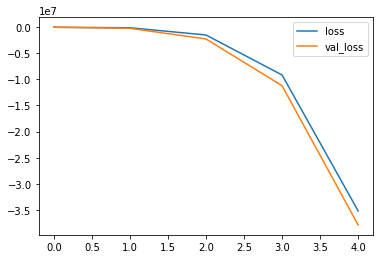

In [31]:
metrics[['loss','val_loss']].plot()


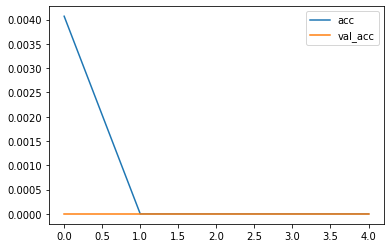

In [32]:
metrics[['acc','val_acc']].plot()

In [0]:
def get_encoded(x):
  x= token.texts_to_sequences(x)
  x = pad_sequences(x, maxlen=max_length, padding='post')
  return x